# Train a deep SNN on the SHD Dataset

In [1]:
import os
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.datasets import HDF5Dataset, DatasetView

from stork.loss_stacks import MeanOfSoftmaxCrossEntropy, SumOfSoftmaxCrossEntropy
from stork.layers import Layer
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DelayGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer,
)

using delay stork version - filter cascades


## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `data/datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [2]:
datadir = "/tungstenfs/scratch/gzenke/datasets/hdspikes"

Next, we specify the Dataset Parameters.

In [3]:
nb_inputs = 700
duration = 1
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 0.7
unit_scale = 1
validation_split = 0.9

sigma_u_augment = 0
dropout_p = 0

In [4]:
train_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=sigma_u_augment,
)

test_gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
    sigma_u_uniform=0,
)

In [5]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **train_gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **test_gen_kwargs)

## Set up the model

In [113]:
# Model Parameters
batch_size = 256
beta = 5
device = torch.device("cuda:0")
dtype = torch.float


nb_hidden_units = 256
nb_hidden_layers = 1
nb_classes = 20

rec = False
stochastic = False
nb_readouts = 1

tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 200e-3
max_delay_time_steps = 250

init_hetero = False
learn_tau_mem = False
learn_tau_syn = False
learn_tau_mem_hetero = False
learn_tau_syn_hetero = False

if learn_tau_mem_hetero:
    learn_tau_mem = True
    init_hetero = False
if learn_tau_syn_hetero:
    learn_tau_syn = True
    init_hetero = False

lr = 1
nb_epochs = 30

In [114]:
act_fn = stork.activations.CustomSpike
if stochastic:
    act_fn.escape_noise_type = "sigmoid"
else:
    act_fn.escape_noise_type = "step"
act_fn.escape_noise_params = {"beta": beta}
act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}

neuron_group = LIFGroup
model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Create regularizers

In [115]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    7  # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time
)
weightL2Strength = 0

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(
    lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False
)
if lowerBoundL2Strength > 0:
    regs.append(regLB)

regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1
)
if upperBoundL2Strength > 0:
    regs.append(regUB)

w_regs = []

regw = stork.regularizers.WeightL2Regularizer(strength=weightL2Strength)
if weightL2Strength > 0:
    w_regs.append(regw)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [116]:
sigma_u = 1.0
nu = 15.8

initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt
)

readout_initializer = DistInitializer()

Add input neuron group

In [117]:
input_group = model.add_group(InputGroup(nb_inputs, dropout_p=dropout_p))

Now we want to add multiple hidden layers as well as regularizers for them

In [118]:
upstream_group = input_group

for l in range(nb_hidden_layers):

    if init_hetero:
        tau_mem_eff = np.random.normal(loc=tau_mem, scale=2e-3)
        tau_syn_eff = np.random.normal(loc=tau_syn, scale=1e-3)
    else:
        tau_mem_eff = tau_mem
        tau_syn_eff = tau_syn

    delay_neurons = model.add_group(
        DelayGroup(
            src=upstream_group,
            max_delay_timesteps=max_delay_time_steps,
            name="delay " + str(l + 1),
        )
    )
    upstream_group = delay_neurons

    hidden_layer = Layer(
        "hidden " + str(l + 1),
        model,
        nb_hidden_units,
        upstream_group,
        recurrent=rec,
        regs=regs,
        w_regs=w_regs,
        neuron_kwargs=dict(
            tau_mem=tau_mem_eff,
            tau_syn=tau_syn_eff,
            activation=act_fn,
            dropout_p=dropout_p,
            learn_tau_mem=learn_tau_mem,
            learn_tau_syn=learn_tau_syn,
            learn_tau_mem_hetero=learn_tau_mem_hetero,
            learn_tau_syn_hetero=learn_tau_syn_hetero,
        ),
        connection_kwargs={"requires_grad": False}
    )

    upstream_group = hidden_layer.output_group

    initializer.initialize(hidden_layer)



if init_hetero:
    tau_readout_eff = np.random.normal(loc=tau_readout, scale=20e-3)
    tau_syn_eff = np.random.normal(loc=tau_syn, scale=1e-3)
else:
    tau_readout_eff = tau_readout
    tau_syn_eff = tau_syn

readout_group = model.add_group(
    ReadoutGroup(
        nb_classes,
        tau_mem=tau_readout_eff,
        tau_syn=tau_syn_eff,
        initial_state=-1e-2,
    )
)
con_ro = model.add_connection(Connection(upstream_group, readout_group))
readout_initializer.initialize(con_ro)

Add monitors for spikes and membrane potential

In [119]:
for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1 + i]))

for i in range(nb_hidden_layers):
    model.add_monitor(stork.monitors.StateMonitor(model.groups[1 + i], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [120]:
loss_stack = SumOfSoftmaxCrossEntropy()

We select the SMORMS3 optimizer

In [121]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [122]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

Before we train the model, we monitor the spikes (ca. 20s)

In [123]:
# Monitors spike counts before training
results = {}
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(nb_hidden_layers)]
results["avg_layer_freq_init"] = [
    nb / len(test_dataset) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results)

{'avg_layer_freq_init': [31.96904331382509]}


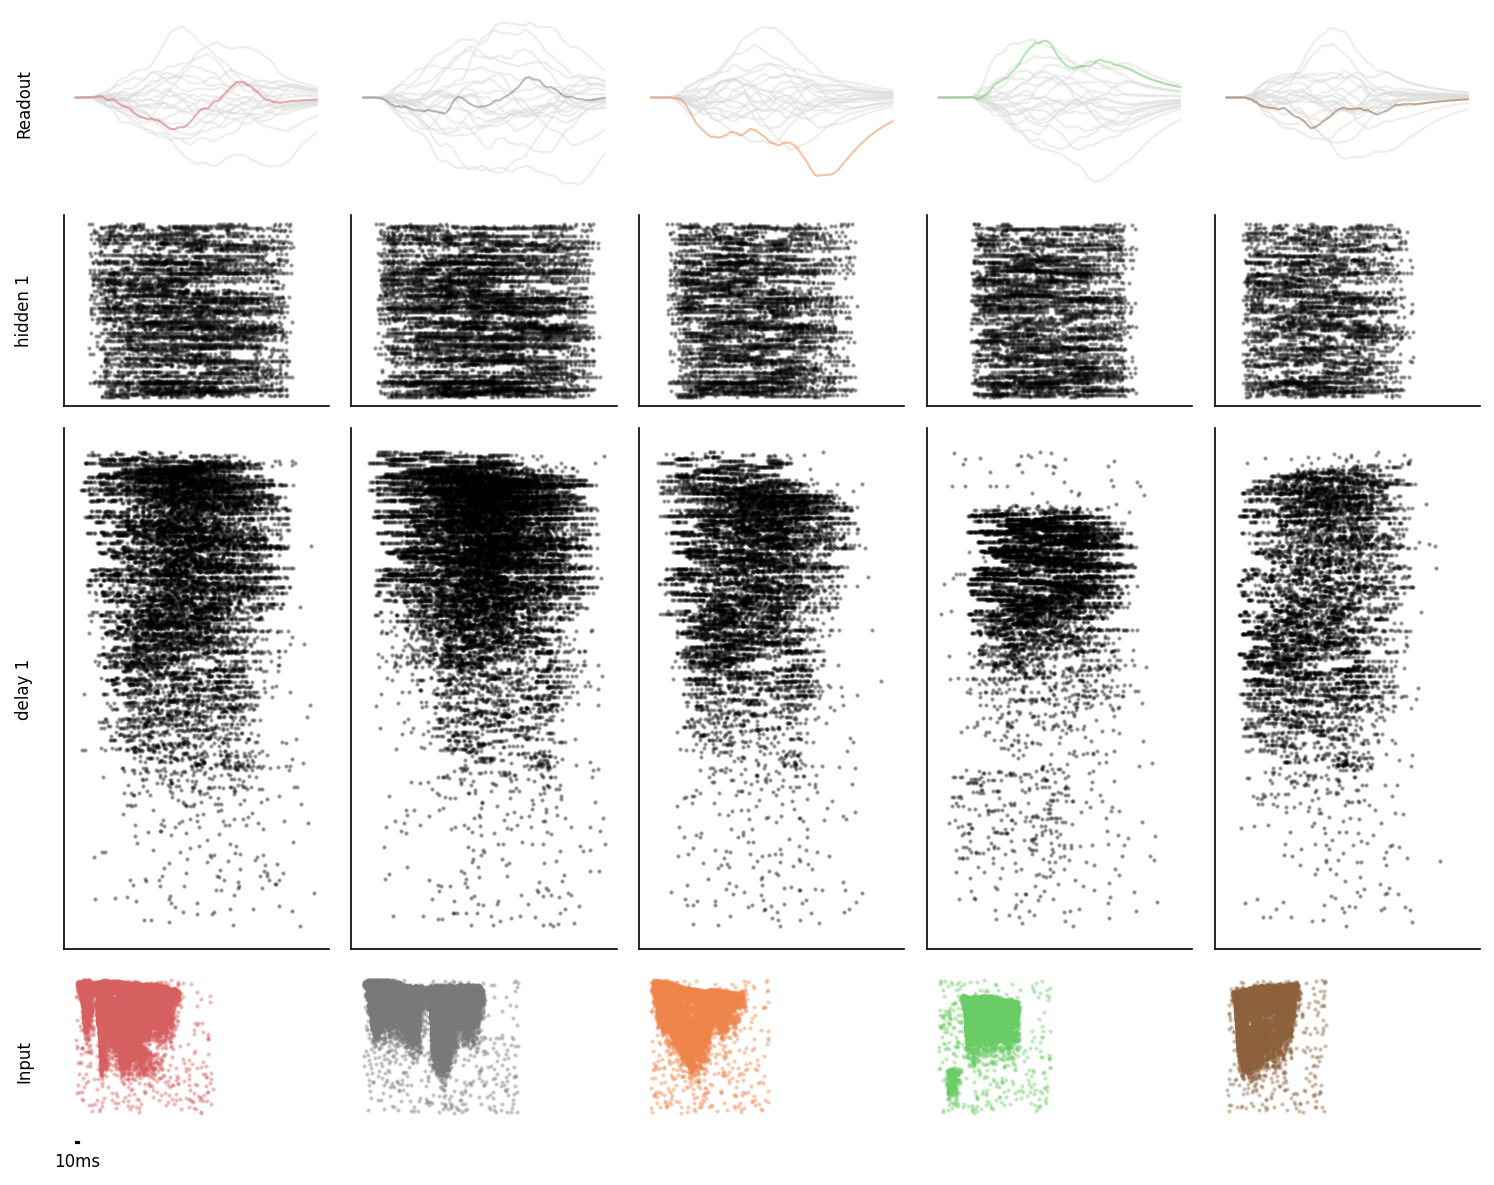

In [124]:
plt.figure(dpi=150, figsize=(10, 8))
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)

## Train

It takes around 50 min using a powerful GPU

(array([12., 19., 10., 18., 13., 11., 16., 15., 14., 18., 16., 11., 16.,
        16.,  9., 16., 19., 19., 18., 16.,  8., 15., 11., 12., 19., 11.,
        15., 13., 20.,  7., 11., 10., 16., 12., 16., 14., 15., 18., 10.,
        19., 12., 12., 14., 16., 11., 12., 11., 20.,  9.,  9.]),
 array([  1.08024478,   6.05649471,  11.03274441,  16.00899315,
         20.98524284,  25.96149254,  30.93774223,  35.91399384,
         40.89024353,  45.86649323,  50.84274292,  55.81899261,
         60.79524231,  65.771492  ,  70.7477417 ,  75.72399139,
         80.70024109,  85.67649078,  90.65274048,  95.62899017,
        100.60523987, 105.58148956, 110.55773926, 115.53398895,
        120.51023865, 125.48648834, 130.46273804, 135.4389801 ,
        140.41523743, 145.39147949, 150.36773682, 155.34397888,
        160.32023621, 165.29647827, 170.2727356 , 175.24897766,
        180.22523499, 185.20147705, 190.17773438, 195.15397644,
        200.13023376, 205.10647583, 210.08273315, 215.05897522,
        220.

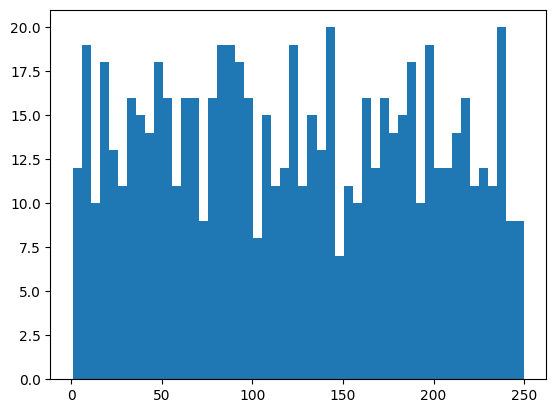

In [125]:
plt.hist(delay_neurons.delays.detach().cpu().numpy(), bins=50)

In [126]:
history = model.fit_validate(
    train_dataset, valid_dataset, nb_epochs=nb_epochs, verbose=True
)

00  loss=258 reg_loss=13.3 acc=0.0541 -- val_loss=208 val_reg_loss=13.6 val_acc=0.0651 t_iter=25.17
01  loss=210 reg_loss=11.9 acc=0.0673 -- val_loss=204 val_reg_loss=11.4 val_acc=0.0671 t_iter=24.53
02  loss=209 reg_loss=10.5 acc=0.0654 -- val_loss=205 val_reg_loss=11.3 val_acc=0.0771 t_iter=24.99
03  loss=210 reg_loss=10.8 acc=0.0618 -- val_loss=205 val_reg_loss=11.7 val_acc=0.0638 t_iter=24.79
04  loss=169 reg_loss=11.3 acc=0.0578 -- val_loss=147 val_reg_loss=11.9 val_acc=0.0791 t_iter=24.87
05  loss=137 reg_loss=11.1 acc=0.0709 -- val_loss=125 val_reg_loss=11.7 val_acc=0.0654 t_iter=24.66
06  loss=120 reg_loss=11.1 acc=0.0661 -- val_loss=114 val_reg_loss=11.9 val_acc=0.0583 t_iter=24.58
07  loss=115 reg_loss=11.3 acc=0.0692 -- val_loss=113 val_reg_loss=11.5 val_acc=0.0765 t_iter=24.74
08  loss=112 reg_loss=11 acc=0.0831 -- val_loss=111 val_reg_loss=11.4 val_acc=0.0905 t_iter=24.25
09  loss=111 reg_loss=10.7 acc=0.0899 -- val_loss=109 val_reg_loss=11.1 val_acc=0.0951 t_iter=25.10
10

In [127]:
if "train_loss" in results:
    results["train_loss"] += history["loss"].tolist()
    results["train_acc"] += history["acc"].tolist()
    results["valid_loss"] += history["val_loss"].tolist()
    results["valid_acc"] += history["val_acc"].tolist()
else:
    results["train_loss"] = history["loss"].tolist()
    results["train_acc"] = history["acc"].tolist()
    results["valid_loss"] = history["val_loss"].tolist()
    results["valid_acc"] = history["val_acc"].tolist()

Monitor the model again after training

In [128]:
res = model.monitor(test_dataset)
total_spikes_per_layer = [torch.sum(res[i]).item() for i in range(nb_hidden_layers)]
results["avg_layer_freq"] = [
    nb / len(test_dataset) / duration / nb_hidden_units for nb in total_spikes_per_layer
]

print(results["avg_layer_freq"])

[26.390514575971732]


## Test

In [129]:
scores = model.evaluate(test_dataset).tolist()
results["test_loss"], _, results["test_acc"] = scores

Test loss:  77.76058366563585
Test acc.:  0.16885288065843623


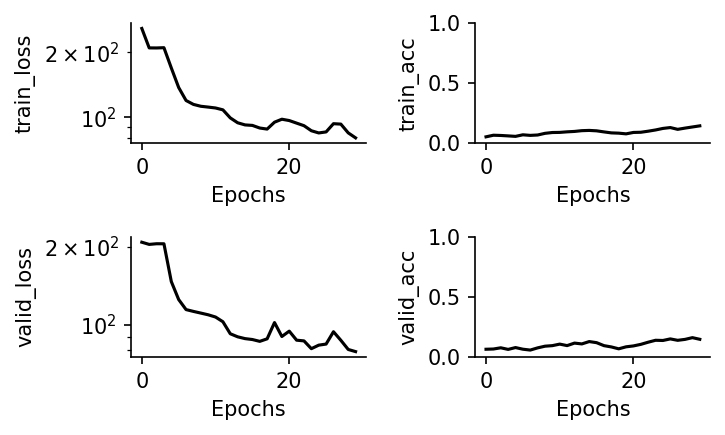

In [130]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["train_loss", "train_acc", "valid_loss", "valid_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

    if "loss" in n:
        a.set_yscale("log")

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"])
print("Test acc.: ", results["test_acc"])

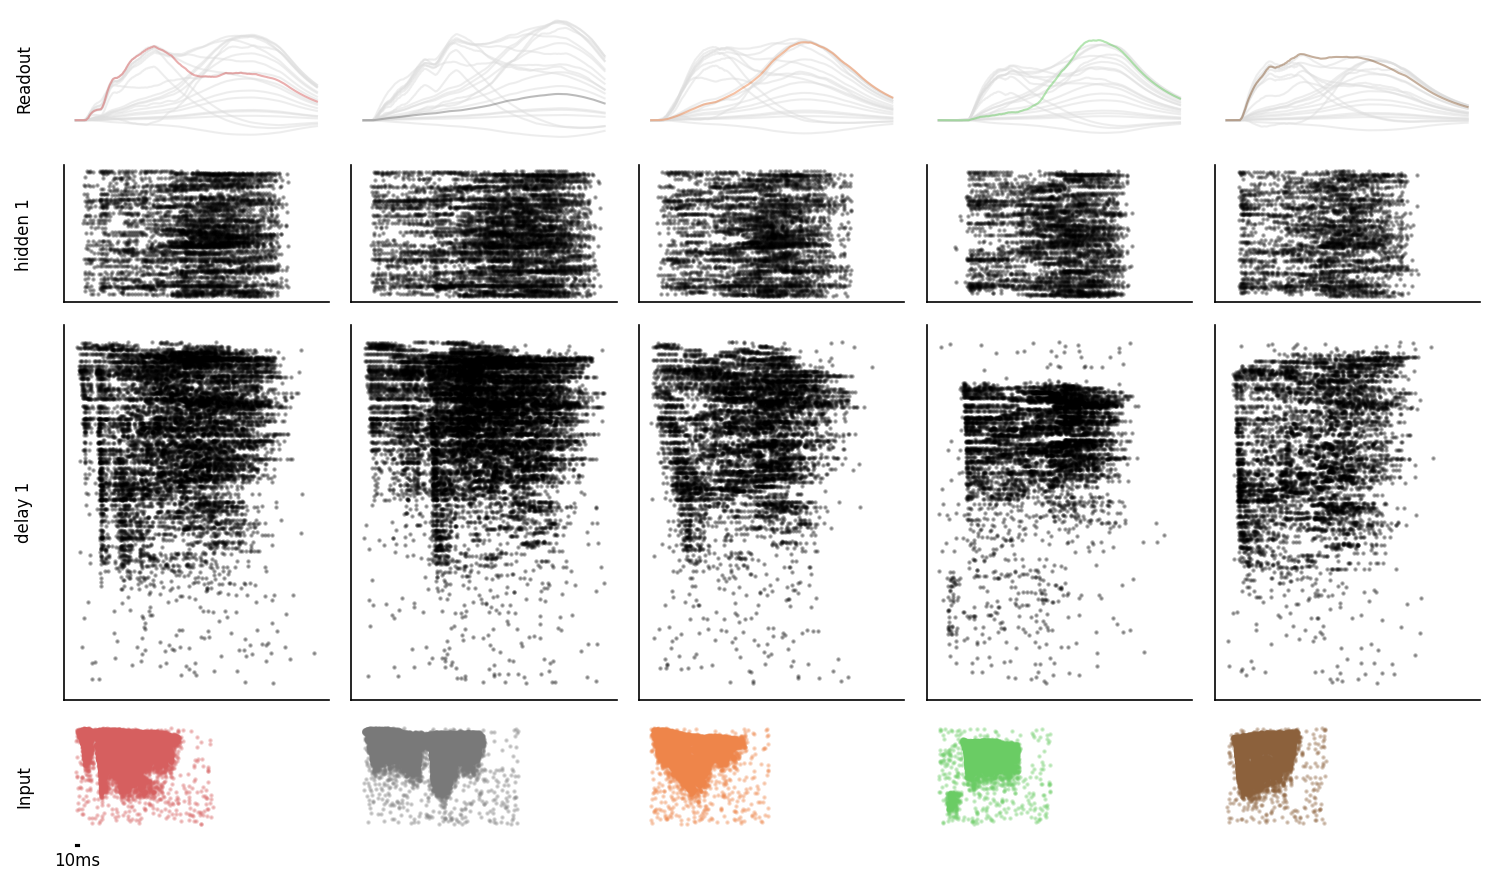

In [131]:
plt.figure(dpi=150, figsize=(10, 6))
stork.plotting.plot_activity_snapshot(
    model, data=test_dataset, nb_samples=5, point_alpha=0.3
)

(array([173.,  10.,  11.,  13.,  16.,  11.,  21.,  22.,  20.,  23.,  25.,
         20.,  21.,  37.,  33.,  24.,  31.,  25.,  18.,  13.,   9.,  15.,
         14.,   8.,  13.,   5.,   8.,  11.,   4.,   6.,   6.,   7.,   5.,
          7.,   3.,   1.,   2.,   2.,   2.,   1.,   0.,   1.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([ -1.04041934,  11.55810261,  24.15662384,  36.75514603,
         49.35366821,  61.9521904 ,  74.55071259,  87.14923096,
         99.74775696, 112.34627533, 124.94480133, 137.5433197 ,
        150.1418457 , 162.7403717 , 175.33888245, 187.93740845,
        200.53593445, 213.13446045, 225.73297119, 238.33149719,
        250.93002319, 263.52853394, 276.1270752 , 288.72558594,
        301.32409668, 313.92263794, 326.52114868, 339.11968994,
        351.71820068, 364.31671143, 376.91525269, 389.51376343,
        402.11227417, 414.71081543, 427.30932617, 439.90783691,
        452.50637817, 465.10488892, 477.70343018, 490.30194092,
        502.900451

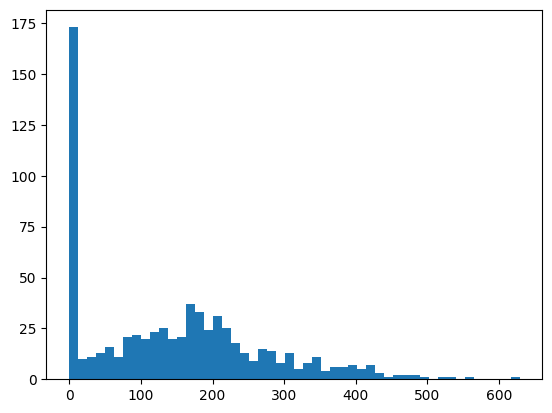

In [132]:
plt.hist(delay_neurons.delays.detach().cpu().numpy(), bins=50)